# Plot and Validate TESS Transits

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import batman
from bls_fit import time, flux, flux_err

In [13]:
# Time conversion
petigura_offset = 2454833
tess_offset = 2457000

def convert_time_t2p(times):
    BTJD = times + tess_offset
    return BTJD - petigura_offset

In [14]:
# Prepare time and flux
time = time.value
time = convert_time_t2p(time)

flux = flux.value
flux_err = flux_err.value

In [15]:
# Transit parameters from NASA exoplanet archive
per_b = 7.9222
rp_b = 0.0777
T14_b = 3.237 * 0.0416667
b_b = 0.17
q1_b = 0.4
q2_b = 0.3

In [17]:
# Transit windows
buffer = 1.5 * T14_b
df_tess = pd.read_csv('tess_transit_data.csv')
transit_times = np.array(df_tess["Tc(TESS)"])
# transit_times = [
#     4697.289029080774, 4713.127343841249, 4721.041829879279, 4728.959652590447,
#     4736.880811974289, 4744.798634685457, 5433.878773628148, 5449.720258227197
# ]

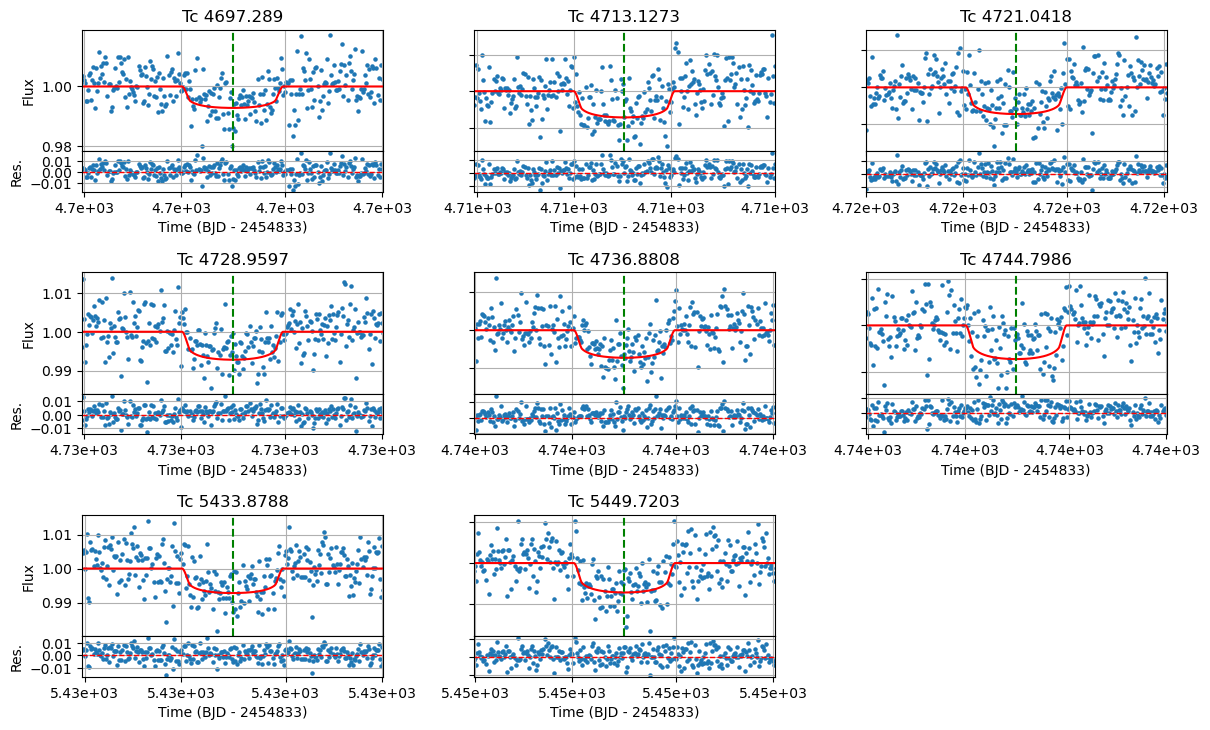

In [24]:
cols = 3
rows = int(np.ceil(len(transit_times) / cols))

fig = plt.figure(figsize=(14, rows * 2.8))
outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)

for i, t0 in enumerate(transit_times):
    row = i // cols
    col = i % cols
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                             height_ratios=[3, 1], hspace=0.0)  # Panels touch

    t_min = t0 - buffer
    t_max = t0 + buffer
    mask = (time >= t_min) & (time <= t_max)

    # Transit model
    theta_initial = [t0, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
    params = batman.TransitParams()
    params.t0, params.per, params.rp, params.b, params.T14, q1, q2 = theta_initial
    params.u = [2 * np.sqrt(q1) * q2, np.sqrt(q1) * (1 - 2 * q2)]
    params.limb_dark = 'quadratic'

    m = batman.TransitModel(params, time[mask])
    model_flux = m.light_curve(params)
    residuals = flux[mask] - model_flux

    # Top panel: model
    ax1 = fig.add_subplot(inner[0])
    ax1.scatter(time[mask], flux[mask], s=5)
    ax1.plot(time[mask], model_flux, color='red')
    ax1.axvline(t0, color='green', linestyle='--')
    ax1.set_title(f'Tc {round(t0, 4)}')
    ax1.set_xlim(t_min, t_max)
    ax1.grid(True)
    ax1.tick_params(labelbottom=False)

    # Bottom panel: residuals
    ax2 = fig.add_subplot(inner[1], sharex=ax1)
    ax2.scatter(time[mask], residuals, s=5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlim(t_min, t_max)
    ax2.set_xlabel(f"Time (BJD - {petigura_offset})")
    ax2.grid(True)

    # Only show y-axis labels for first column
    if col == 0:
        ax1.set_ylabel("Flux")
        ax2.set_ylabel("Res.")
    else:
        ax1.set_ylabel("")
        ax1.tick_params(labelleft=False)
        ax2.set_ylabel("")
        ax2.tick_params(labelleft=False)

    # Custom ticks
    ticks = np.round(np.linspace(t_min, t_max, 4), 2)
    ax2.set_xticks(ticks)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3}"))

plt.show()

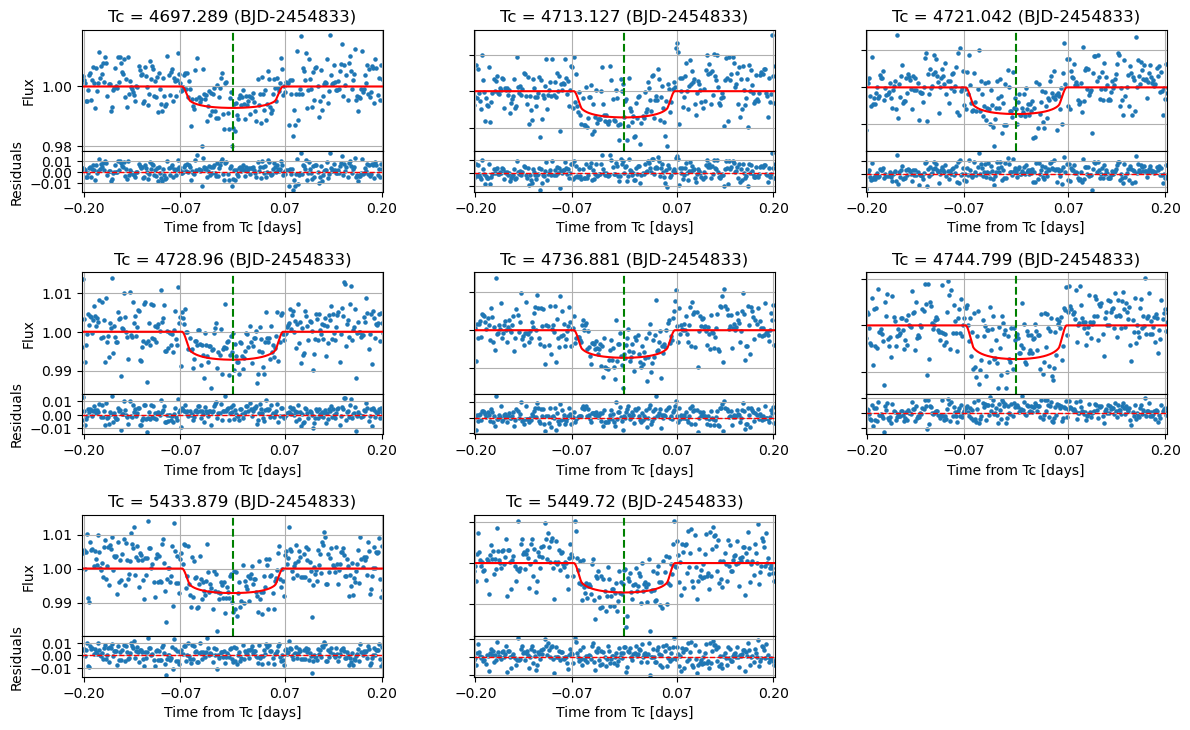

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

cols = 3
rows = int(np.ceil(len(transit_times) / cols))

fig = plt.figure(figsize=(14, rows * 2.8))
outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)

for i, t0 in enumerate(transit_times):
    row = i // cols
    col = i % cols
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                             height_ratios=[3, 1], hspace=0.0)  # Panels touch

    t_min = t0 - buffer
    t_max = t0 + buffer
    mask = (time >= t_min) & (time <= t_max)
    time_rel = time[mask] - t0  # Time relative to Tc

    # Transit model setup
    theta_initial = [t0, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
    params = batman.TransitParams()
    params.t0, params.per, params.rp, params.b, params.T14, q1, q2 = theta_initial
    params.u = [2 * np.sqrt(q1) * q2, np.sqrt(q1) * (1 - 2 * q2)]
    params.limb_dark = 'quadratic'

    m = batman.TransitModel(params, time[mask])
    model_flux = m.light_curve(params)
    residuals = flux[mask] - model_flux

    # Top panel: model + data
    ax1 = fig.add_subplot(inner[0])
    ax1.scatter(time_rel, flux[mask], s=5, label='Data')
    ax1.plot(time_rel, model_flux, color='red', label='Model')
    ax1.axvline(0, color='green', linestyle='--', label='Tc')
    ax1.set_xlim(-buffer, buffer)
    ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{petigura_offset})')
    ax1.grid(True)
    ax1.tick_params(labelbottom=False)

    # Bottom panel: residuals
    ax2 = fig.add_subplot(inner[1], sharex=ax1)
    ax2.scatter(time_rel, residuals, s=5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlim(-buffer, buffer)
    ax2.set_xlabel("Time from Tc [days]")
    ax2.grid(True)

    # Y-axis labels for first column only
    if col == 0:
        ax1.set_ylabel("Flux")
        ax2.set_ylabel("Residuals")
    else:
        ax1.set_ylabel("")
        ax1.tick_params(labelleft=False)
        ax2.set_ylabel("")
        ax2.tick_params(labelleft=False)

    # Custom ticks
    ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
    ax2.set_xticks(ticks)

plt.show()


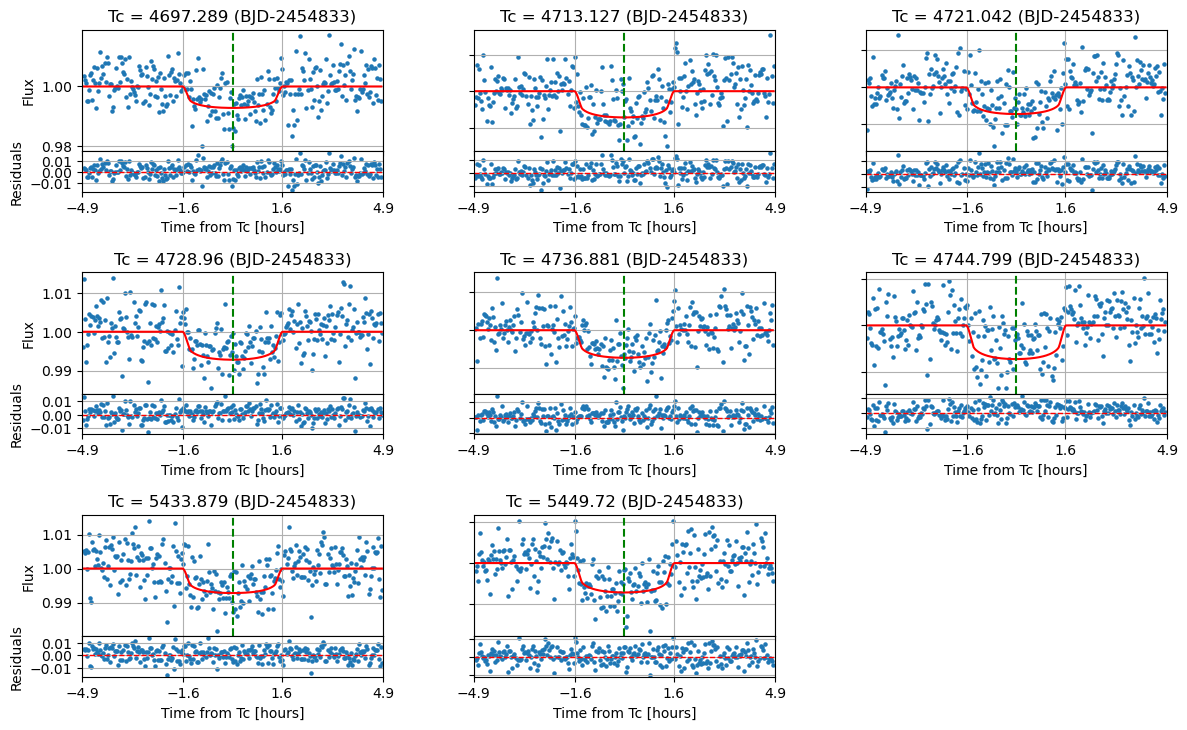

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

cols = 3
rows = int(np.ceil(len(transit_times) / cols))

fig = plt.figure(figsize=(14, rows * 2.8))
outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)

for i, t0 in enumerate(transit_times):
    row = i // cols
    col = i % cols
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                             height_ratios=[3, 1], hspace=0.0)

    t_min = t0 - buffer
    t_max = t0 + buffer
    mask = (time >= t_min) & (time <= t_max)
    
    # Time relative to transit center in hours
    time_rel_hrs = (time[mask] - t0) * 24

    # Transit model setup
    theta_initial = [t0, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
    params = batman.TransitParams()
    params.t0, params.per, params.rp, params.b, params.T14, q1, q2 = theta_initial
    params.u = [2 * np.sqrt(q1) * q2, np.sqrt(q1) * (1 - 2 * q2)]
    params.limb_dark = 'quadratic'

    m = batman.TransitModel(params, time[mask])
    model_flux = m.light_curve(params)
    residuals = flux[mask] - model_flux

    # Top panel
    ax1 = fig.add_subplot(inner[0])
    ax1.scatter(time_rel_hrs, flux[mask], s=5)
    ax1.plot(time_rel_hrs, model_flux, color='red')
    ax1.axvline(0, color='green', linestyle='--')
    ax1.set_xlim(-buffer * 24, buffer * 24)
    ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{petigura_offset})')
    ax1.grid(True)
    ax1.tick_params(labelbottom=False)

    # Bottom panel: residuals
    ax2 = fig.add_subplot(inner[1], sharex=ax1)
    ax2.scatter(time_rel_hrs, residuals, s=5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlim(-buffer * 24, buffer * 24)
    ax2.set_xlabel("Time from Tc [hours]")
    ax2.grid(True)

    # Y-axis for first column only
    if col == 0:
        ax1.set_ylabel("Flux")
        ax2.set_ylabel("Residuals")
    else:
        ax1.set_ylabel("")
        ax1.tick_params(labelleft=False)
        ax2.set_ylabel("")
        ax2.tick_params(labelleft=False)

    # X ticks
    ticks = np.round(np.linspace(-buffer * 24, buffer * 24, 4), 1)
    ax2.set_xticks(ticks)

plt.show()


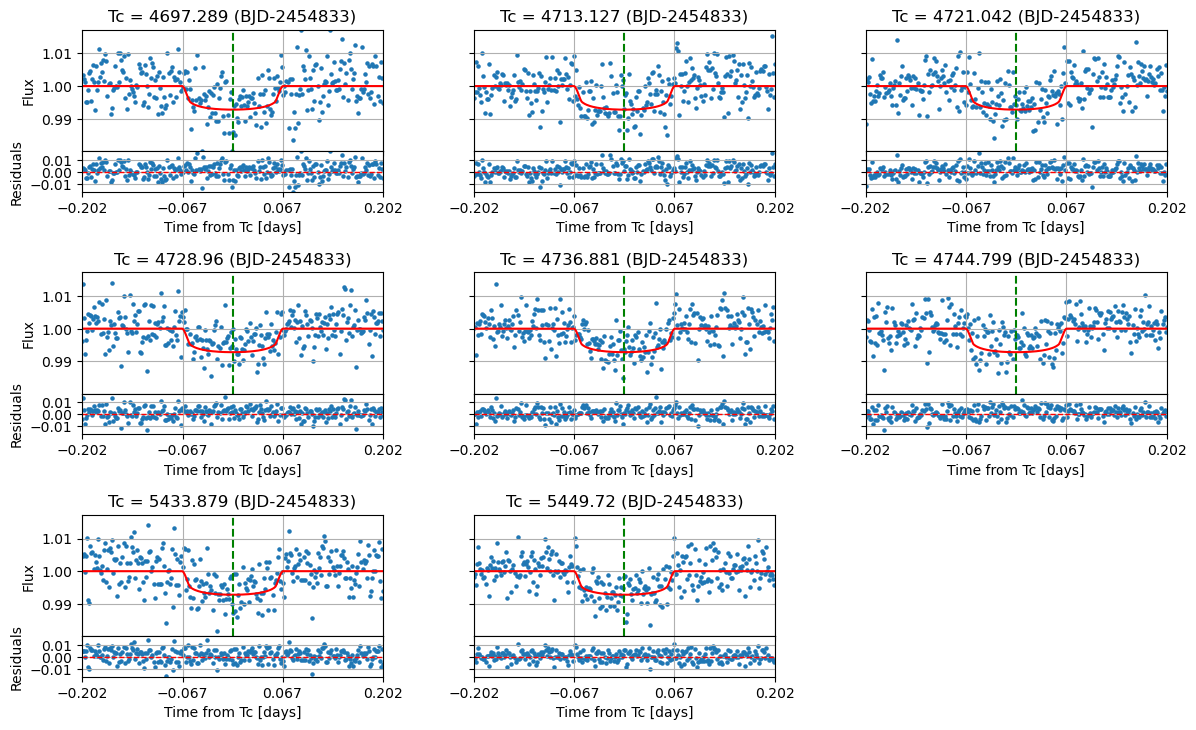

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

cols = 3
rows = int(np.ceil(len(transit_times) / cols))

fig = plt.figure(figsize=(14, rows * 2.8))
outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)

# Track global y-limits
all_flux_values = []
all_residuals = []

# First pass: find global min/max
for t0 in transit_times:
    t_min = t0 - buffer
    t_max = t0 + buffer
    mask = (time >= t_min) & (time <= t_max)

    # Transit model
    theta_initial = [t0, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
    params = batman.TransitParams()
    params.t0, params.per, params.rp, params.b, params.T14, q1, q2 = theta_initial
    params.u = [2 * np.sqrt(q1) * q2, np.sqrt(q1) * (1 - 2 * q2)]
    params.limb_dark = 'quadratic'

    m = batman.TransitModel(params, time[mask])
    model_flux = m.light_curve(params)
    residuals = flux[mask] - model_flux

    all_flux_values.extend(flux[mask])
    all_residuals.extend(residuals)

flux_ylim = [np.min(all_flux_values), np.max(all_flux_values)]
resid_ylim = [np.min(all_residuals), np.max(all_residuals)]

# Second pass: plotting
for i, t0 in enumerate(transit_times):
    row = i // cols
    col = i % cols
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                             height_ratios=[3, 1], hspace=0.0)

    t_min = t0 - buffer
    t_max = t0 + buffer
    mask = (time >= t_min) & (time <= t_max)
    time_rel_days = time[mask] - t0  # Time from Tc in days

    # Transit model
    theta_initial = [t0, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
    params = batman.TransitParams()
    params.t0, params.per, params.rp, params.b, params.T14, q1, q2 = theta_initial
    params.u = [2 * np.sqrt(q1) * q2, np.sqrt(q1) * (1 - 2 * q2)]
    params.limb_dark = 'quadratic'

    m = batman.TransitModel(params, time[mask])
    model_flux = m.light_curve(params)
    residuals = flux[mask] - model_flux

    # Top panel: flux
    ax1 = fig.add_subplot(inner[0])
    ax1.scatter(time_rel_days, flux[mask], s=5)
    ax1.plot(time_rel_days, model_flux, color='red')
    ax1.axvline(0, color='green', linestyle='--')
    ax1.set_xlim(-buffer, buffer)
    ax1.set_ylim(flux_ylim)
    ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{petigura_offset})')
    ax1.grid(True)
    ax1.tick_params(labelbottom=False)

    # Bottom panel: residuals
    ax2 = fig.add_subplot(inner[1], sharex=ax1)
    ax2.scatter(time_rel_days, residuals, s=5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlim(-buffer, buffer)
    ax2.set_ylim(resid_ylim)
    ax2.set_xlabel("Time from Tc [days]")
    ax2.grid(True)

    # Y-axis only on first column
    if col == 0:
        ax1.set_ylabel("Flux")
        ax2.set_ylabel("Residuals")
    else:
        ax1.set_ylabel("")
        ax1.tick_params(labelleft=False)
        ax2.set_ylabel("")
        ax2.tick_params(labelleft=False)

    # Custom x-ticks
    ticks = np.round(np.linspace(-buffer, buffer, 4), 3)
    ax2.set_xticks(ticks)

plt.show()
